<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/FL_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q
!pip install scikit-fuzzy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 37.7 MB/s eta 0:00:00


## MISTRAL

In [1]:
!nvidia-smi

Sat Apr 12 15:34:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             40W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from transformers import pipeline

# 1. Initialize a sentiment analysis pipeline using a Mistral model from Hugging Face
try:
    sentiment_analyzer = pipeline("sentiment-analysis", model="mistralai/Mistral-7B-v0.1")
except Exception as e:
    print(f"Error loading Mistral sentiment analysis model from Hugging Face: {e}")
    print("Please ensure you have the 'transformers' library installed and a network connection.")
    print("Falling back to a simplified simulation.")
    def analyze_sentiment_with_hf_mistral(text):
        if "terrible" in text or "awful" in text or "hate" in text:
            return 0.08
        elif "bad" in text or "disappointed" in text:
            return 0.25
        elif "okay" in text or "not great not bad" in text or "meh" in text:
            return 0.55
        elif "good" in text or "happy" in text or "enjoyed" in text:
            return 0.75
        elif "amazing" in text or "love" in text or "fantastic" in text or "excellent" in text:
            return 0.92
        else:
            return 0.6
    analyze_sentiment_with_hf_mistral_pipeline = analyze_sentiment_with_hf_mistral
else:
    def analyze_sentiment_with_hf_mistral_pipeline(text):
        """
        Analyzes sentiment using a Mistral model from Hugging Face.
        """
        result = sentiment_analyzer(text)[0]
        if result['label'] == 'POSITIVE':
            return result['score']
        elif result['label'] == 'NEGATIVE':
            return 1 - result['score'] # Convert negative score to 0-1 range
        else:
            return 0.5 # Neutral if the model isn't strongly positive or negative

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Customer Review: 'The speed was excellent, but the setup process was quite frustrating.'
Mistral (from HF) Sentiment Score: 0.50
Fuzzy Sentiment Output: 0.500
Degree of Negative: 0.000
Degree of Neutral: 1.000
Degree of Positive: 0.000


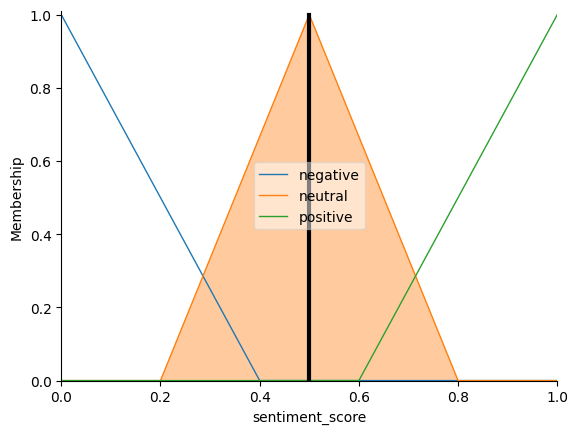

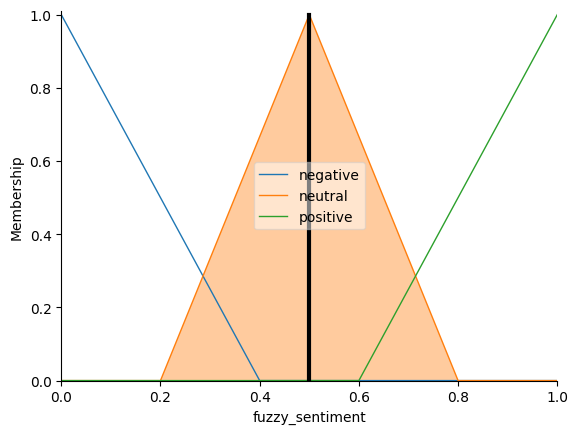

In [3]:
# 2. Define the input variable (LLM Sentiment Score)
sentiment_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'sentiment_score')

# 3. Define the output variable (Fuzzy Sentiment Category)
fuzzy_sentiment = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'fuzzy_sentiment')

# 4. Define the fuzzy membership functions for the input
sentiment_score['negative'] = fuzz.trimf(sentiment_score.universe, [0, 0, 0.4])
sentiment_score['neutral'] = fuzz.trimf(sentiment_score.universe, [0.2, 0.5, 0.8])
sentiment_score['positive'] = fuzz.trimf(sentiment_score.universe, [0.6, 1, 1])

# 5. Define the fuzzy membership functions for the output
fuzzy_sentiment['negative'] = fuzz.trimf(fuzzy_sentiment.universe, [0, 0, 0.4])
fuzzy_sentiment['neutral'] = fuzz.trimf(fuzzy_sentiment.universe, [0.2, 0.5, 0.8])
fuzzy_sentiment['positive'] = fuzz.trimf(fuzzy_sentiment.universe, [0.6, 1, 1])

# 6. Define the fuzzy rules
rule1 = ctrl.Rule(sentiment_score['negative'], fuzzy_sentiment['negative'])
rule2 = ctrl.Rule(sentiment_score['neutral'], fuzzy_sentiment['neutral'])
rule3 = ctrl.Rule(sentiment_score['positive'], fuzzy_sentiment['positive'])

# 7. Create the control system
sentiment_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
sentiment_evaluation = ctrl.ControlSystemSimulation(sentiment_ctrl)

# 8. Example usage with Mistral from Hugging Face
customer_review = "The speed was excellent, but the setup process was quite frustrating."
mistral_sentiment_output = analyze_sentiment_with_hf_mistral_pipeline(customer_review)

# 9. Feed the Mistral output into the fuzzy system
sentiment_evaluation.input['sentiment_score'] = mistral_sentiment_output
sentiment_evaluation.compute()

# 10. Get the fuzzy output
print(f"Customer Review: '{customer_review}'")
print(f"Mistral (from HF) Sentiment Score: {mistral_sentiment_output:.2f}")
print(f"Fuzzy Sentiment Output: {sentiment_evaluation.output['fuzzy_sentiment']:.3f}")

# You can also see the degree of membership in each fuzzy set
negative_membership = fuzz.interp_membership(sentiment_score.universe, sentiment_score['negative'].mf, mistral_sentiment_output)
neutral_membership = fuzz.interp_membership(sentiment_score.universe, sentiment_score['neutral'].mf, mistral_sentiment_output)
positive_membership = fuzz.interp_membership(sentiment_score.universe, sentiment_score['positive'].mf, mistral_sentiment_output)

print(f"Degree of Negative: {negative_membership:.3f}")
print(f"Degree of Neutral: {neutral_membership:.3f}")
print(f"Degree of Positive: {positive_membership:.3f}")

# Optional: Visualize the membership functions and the result
sentiment_score.view(sim=sentiment_evaluation)
fuzzy_sentiment.view(sim=sentiment_evaluation)

## LLAMA

In [1]:
!nvidia-smi

Sat Apr 12 15:30:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             40W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from transformers import pipeline

# 1. Initialize a sentiment analysis pipeline using a Mistral model from Hugging Face
try:
    sentiment_analyzer = pipeline("sentiment-analysis", model="meta-llama/Meta-Llama-3-8B")
except Exception as e:
    print(f"Error loading  LLAMA sentiment analysis model from Hugging Face: {e}")
    print("Please ensure you have the 'transformers' library installed and a network connection.")
    print("Falling back to a simplified simulation.")
    def analyze_sentiment_with_hf_llama(text):
        if "terrible" in text or "awful" in text or "hate" in text:
            return 0.08
        elif "bad" in text or "disappointed" in text:
            return 0.25
        elif "okay" in text or "not great not bad" in text or "meh" in text:
            return 0.55
        elif "good" in text or "happy" in text or "enjoyed" in text:
            return 0.75
        elif "amazing" in text or "love" in text or "fantastic" in text or "excellent" in text:
            return 0.92
        else:
            return 0.6
    analyze_sentiment_with_hf_llama_pipeline = analyze_sentiment_with_hf_llama
else:
    def analyze_sentiment_with_hf_llama_pipeline(text):
        """
        Analyzes sentiment using a LLAMA model from Hugging Face.
        """
        result = sentiment_analyzer(text)[0]
        if result['label'] == 'POSITIVE':
            return result['score']
        elif result['label'] == 'NEGATIVE':
            return 1 - result['score'] # Convert negative score to 0-1 range
        else:
            return 0.5 # Neutral if the model isn't strongly positive or negative


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Customer Review: 'The speed was excellent, but the setup process was quite frustrating.'
LLAMA (from HF) Sentiment Score: 0.50
Fuzzy Sentiment Output: 0.500
Degree of Negative: 0.000
Degree of Neutral: 1.000
Degree of Positive: 0.000


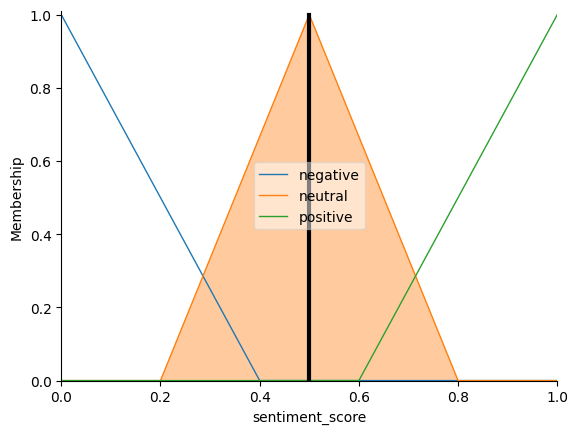

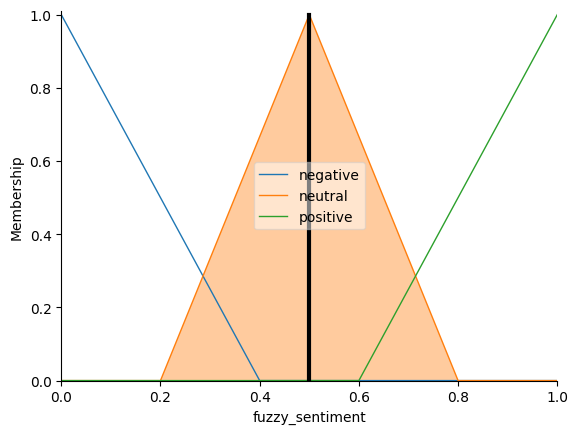

In [3]:
# 2. Define the input variable (LLM Sentiment Score)
sentiment_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'sentiment_score')

# 3. Define the output variable (Fuzzy Sentiment Category)
fuzzy_sentiment = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'fuzzy_sentiment')

# 4. Define the fuzzy membership functions for the input
sentiment_score['negative'] = fuzz.trimf(sentiment_score.universe, [0, 0, 0.4])
sentiment_score['neutral'] = fuzz.trimf(sentiment_score.universe, [0.2, 0.5, 0.8])
sentiment_score['positive'] = fuzz.trimf(sentiment_score.universe, [0.6, 1, 1])

# 5. Define the fuzzy membership functions for the output
fuzzy_sentiment['negative'] = fuzz.trimf(fuzzy_sentiment.universe, [0, 0, 0.4])
fuzzy_sentiment['neutral'] = fuzz.trimf(fuzzy_sentiment.universe, [0.2, 0.5, 0.8])
fuzzy_sentiment['positive'] = fuzz.trimf(fuzzy_sentiment.universe, [0.6, 1, 1])

# 6. Define the fuzzy rules
rule1 = ctrl.Rule(sentiment_score['negative'], fuzzy_sentiment['negative'])
rule2 = ctrl.Rule(sentiment_score['neutral'], fuzzy_sentiment['neutral'])
rule3 = ctrl.Rule(sentiment_score['positive'], fuzzy_sentiment['positive'])

# 7. Create the control system
sentiment_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
sentiment_evaluation = ctrl.ControlSystemSimulation(sentiment_ctrl)

# 8. Example usage with Mistral from Hugging Face
customer_review = "The speed was excellent, but the setup process was quite frustrating."
llama_sentiment_output = analyze_sentiment_with_hf_llama_pipeline(customer_review)

# 9. Feed the Mistral output into the fuzzy system
sentiment_evaluation.input['sentiment_score'] = llama_sentiment_output
sentiment_evaluation.compute()

# 10. Get the fuzzy output
print(f"Customer Review: '{customer_review}'")
print(f"LLAMA (from HF) Sentiment Score: {llama_sentiment_output:.2f}")
print(f"Fuzzy Sentiment Output: {sentiment_evaluation.output['fuzzy_sentiment']:.3f}")

# You can also see the degree of membership in each fuzzy set
negative_membership = fuzz.interp_membership(sentiment_score.universe, sentiment_score['negative'].mf, llama_sentiment_output)
neutral_membership = fuzz.interp_membership(sentiment_score.universe, sentiment_score['neutral'].mf, llama_sentiment_output)
positive_membership = fuzz.interp_membership(sentiment_score.universe, sentiment_score['positive'].mf, llama_sentiment_output)

print(f"Degree of Negative: {negative_membership:.3f}")
print(f"Degree of Neutral: {neutral_membership:.3f}")
print(f"Degree of Positive: {positive_membership:.3f}")

# Optional: Visualize the membership functions and the result
sentiment_score.view(sim=sentiment_evaluation)
fuzzy_sentiment.view(sim=sentiment_evaluation)